In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import pyproj
from shapely.ops import transform
from helper import *

In [65]:
# enter resolution of grid in meters
grid_resolution=1000
# The majority of Costa Rica is in UTM zone 17, but the western part is in UTM zone 17. We will use UTM zone 17 for this analysis
utm_code = "EPSG:32617"
# add the directory which contains all species data here
directory = "C:\\Users\\olive\\Box Sync\\Hotspot Stoplight Data\\IUCN Threatened Species"
# directory = "D:\\hotspot mapping\\Data"
species_list=[x[1] for x in os.walk(directory)][0]
species_filepath_dict={species:os.path.join(directory,species,"{}.shp".format(species)) for species in species_list}
# species_filepath_dict={species:os.path.join(directory,species,species,"{}.shp".format(species)) for species in species_list}

In [66]:
# get the area of interest from a geojson file
# cr_polygon=gpd.read_file('C:\\Users\\olive\\Box Sync\\Hotspot Stoplight Data\\resourceshedbb_CostaRica_SanJose.geojson').geometry[0]
cr_polygon=gpd.read_file('C:\\Users\\olive\\Box Sync\\Hotspot Stoplight Data\\CR_Crop2.geojson').geometry[0]
project = pyproj.Transformer.from_proj(
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init=utm_code)) # destination coordinate system
project_reverse = pyproj.Transformer.from_proj(
        pyproj.Proj(init=utm_code), # source coordinate system
        pyproj.Proj(init='epsg:4326')) # destination coordinate system
cr_polygon_utm = transform(project.transform, cr_polygon)

c:\Users\olive\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\olive\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\olive\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

In [67]:
final_dict={}
# generate grid
grid = create_grid(resolution=grid_resolution, target_polygon=cr_polygon_utm)
# get the centroids of each polygon in the grid and convert to epsg 4326
centroids = [transform(project_reverse.transform, poly.centroid) for poly in grid]
# print(len(centroids))
for species, file_path in species_filepath_dict.items():
    # get and convert geo series to utm
    species_geo = filter_species(path= file_path, target_polygon=cr_polygon)
    # species_geo_utm = species_geo.to_crs(utm_code)
    species_count = count_species(species_geo, centroids)
    # plot_abundance(species_count,species_name=species)
    final_dict['count_{}'.format(species)]=species_count
    print("{} done".format(species))
    # break
final_df = gpd.GeoDataFrame(final_dict)

AMPHIBIANS done
MAMMALS done
REPTILES done


C:\Users\olive\AppData\Local\Temp\ipykernel_3708\2704498792.py:4: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  final_df['geometry']=grid


Text(0.5, 1.0, 'Threatened Species Abundance')

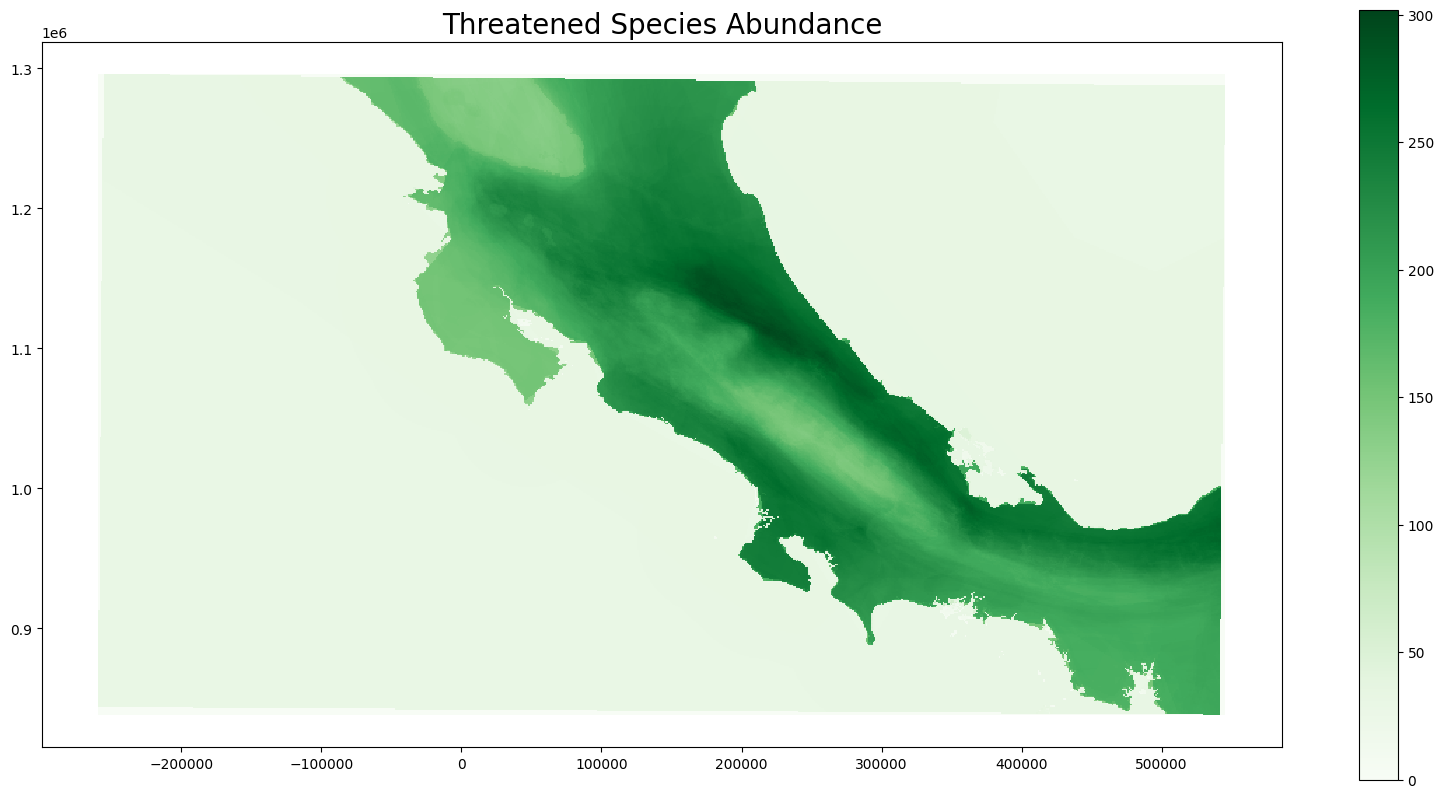

In [68]:
# get the sum of all species
final_df['species_count']=final_df.sum(axis=1)
# add the grid to the dataframe
final_df['geometry']=grid
# convert geometry to lat/lon
# final_df['lon'] = final_df['geometry'].x
# final_df['lat'] = final_df['geometry'].y
# plot the total species count
fig, ax = plt.subplots(figsize=(20,10))
# gpd.GeoSeries(cr_polygon).plot(ax=ax, color='white', edgecolor='black')
# # plot costa rica map
# cr_map=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
# cr_map.plot(ax=ax, color='white', edgecolor='black')
# use a colormap to plot the species count
final_df.plot(ax=ax, column='species_count', legend=True, cmap='Greens')
# set the title
ax.set_title('Threatened Species Abundance', fontsize=20)

In [69]:
# save the data
final_df.to_csv("IUCN_Species_CR.csv")

In [70]:
final_gdf = gpd.GeoDataFrame(final_df[['species_count','geometry']],geometry='geometry',crs=utm_code)
# save the data as geo tiff
ord = output_geotiff(final_gdf,"./IUCN_Species_CR.tif",grid_resolution)

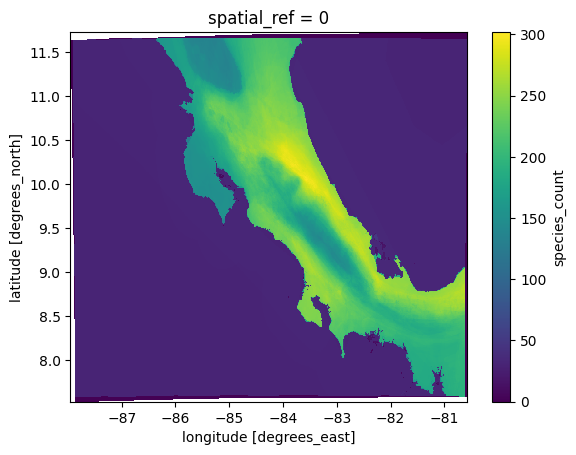

In [71]:
ord.species_count.plot()